# Homework no: 7 - Makeup Mid Semester
### Name : ANGGARA PUTRA PRATAMA - 1101174240 
github.com/anggaraputrapratama

In [89]:
%matplotlib inline
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.util.shape import view_as_windows
from scipy.signal import find_peaks, peak_prominences
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets

In [90]:
#Given id for each label
axis_label = {0:'ax', 1:'ay', 2:'az', 4:'am'}

#Frequency Sampling
fs = 52

output_path = ''
outputpath = pathlib.Path(output_path)

def freq_analysis(data2, path1):
#Use for loop to plot the figure of label 1
    for i in range (1,8):
        mask1 = data2[:,3]==i
        #Assign label
        label_list = []
        header = 'ax_b, ax_dc, ax_ac, ay_b, ay_dc, ay_ac, az_b, az_dc, az_ac, am_b, am_dc, am_ac'
        for j in axis_label:
            alx = data2[mask1,j]
        
            #Cut lenght 10% from two ends
            n = len(alx)
            #Use int to define cut lenght
            cut_len = int(n*0.1)
            b = alx[cut_len:-cut_len]
            m = b.size
        
            #Convert data into frequency domain
            freqY = np.fft.fft(b)
            freq = np.fft.fftfreq(m, d=1/fs)
            shift_freq = np.fft.fftshift(freq)
                
            #Spectrum
            spectrum = np.sqrt(freqY.real**2+freqY.imag**2)               
            shift_spec = np.fft.fftshift(spectrum)
            spec = np.fft.ifft(spectrum)                   
                
            #Low pass filter
            lowPassMask = abs(freq) <=1 #Cut off 1hz
            lowPassFy = freqY.copy()
            lowPassFy[~lowPassMask] = 0 # ~, equivalent to logical_not
            dc = np.fft.ifft(lowPassFy)
        
            #High pass filter
            highPassFy = freqY.copy()
            highPassFy[lowPassMask] = 0 
            ac = np.fft.ifft(highPassFy)
        
            #Reshape b, dc, ac and append to label list 
            label_list.append(b.reshape(-1,1))
            label_list.append(dc.real.reshape(-1,1))
            label_list.append(ac.real.reshape(-1,1))
                        
        #Store the results
        arrange_table = np.hstack(label_list)
        np.savetxt('{}/label_{}.csv'.format(path1, i), arrange_table, delimiter=',', fmt='%.18f', header=header, comments='')

In [91]:
def feature_extraction(path2):
    #Read several dataset in one folder using pathlib and glob
    data_path = pathlib.Path(path2)
    data_files = sorted(data_path.glob('label*.csv'))

        #Define function for mean minmax sum calculation
    def mean_minmax_sum(data3):
        minmax = np.zeros(data3.shape[0], dtype=np.float32)
        for i in range(data3.shape[0]):
            min_peaks, _ = find_peaks(-data3[i])
            max_peaks, _ = find_peaks(data3[i])
        
            n = min(min_peaks.size, max_peaks.size)
            if n > 0:
                loc_min = data3[i, min_peaks[:n]]
                loc_max = data3[i, max_peaks[:n]]
                differences = loc_max - loc_min
                average = differences.sum() / n
            else:
                average = np.nan
            minmax[i] = average
        return minmax

    #Define function for rms velocity calculation
    def rms_velocity(x):
        z = view_as_windows(x, (10), 1)
        v = np.sum(z, axis = 1)
        z = view_as_windows(v, (52,), 26)
        rms = np.sqrt(np.mean(np.square(z), axis = 1))
        return rms

    #Calculation process
    for j, f in enumerate(data_files):
        print(j, f.name)
        #Use pandas dataframe to read dataset
        df = pd.read_csv(f)
        data4 = df.values
        feature_list = []
        header = ''
        for k in range(12):
            a = data4[:,k]
            b = view_as_windows(a, (52,), 26)
            mean = np.mean(b, axis = 1)
            std = np.std(b, axis = 1)
            minmax = mean_minmax_sum(b)
            rms = rms_velocity(a)
        
            nrows = min(b.shape[0], rms.shape[0], minmax.shape[0])
            feature_list.append(mean[:nrows].reshape(-1,1))
            feature_list.append(std[:nrows].reshape(-1,1))
            feature_list.append(minmax[:nrows].reshape(-1,1))
            feature_list.append(rms[:nrows].reshape(-1,1))
        
            header += 'mean_(0), std_(0), minmax_(0), rms_(0),'.format(df.columns[k])
            arrange = np.hstack(feature_list)
           
        #Store the results
        print(arrange.shape)
        np.savetxt('{}/features_{}.csv'.format(path2, j+1), arrange, delimiter=',', fmt='%.18f', header=header, comments='')

In [92]:
for i in range(1, 16):
    file_name = 'data/{}.csv'.format(i)
    print("process file, ", file_name)
    data = np.genfromtxt(file_name, delimiter=',', usecols=(1,2,3,4), dtype='int32')
    
    mask0 = data[:,-1] > 0
    mask1 = data[:,-1] <= 7
    mask = mask0 & mask1
    
    data1 = data[mask,]
    
    ax = data1[:,0]
    ay = data1[:,1]
    az = data1[:,2]
    am = np.sqrt(ax*ax+ay*ay+az*az)
    
    am = am.reshape(-1,1)
    data2 = np.hstack([data1, am])
    
    output_user_path = outputpath.joinpath('user{}'.format(i))
    if not output_user_path.exists():
        output_user_path.mkdir()
        
    freq_analysis(data2, str(output_user_path))

process file,  data/1.csv
process file,  data/2.csv
process file,  data/3.csv
process file,  data/4.csv
process file,  data/5.csv
process file,  data/6.csv
process file,  data/7.csv
process file,  data/8.csv
process file,  data/9.csv
process file,  data/10.csv
process file,  data/11.csv
process file,  data/12.csv
process file,  data/13.csv
process file,  data/14.csv
process file,  data/15.csv


In [93]:
for i in range(1,16):
    user_path = outputpath.joinpath('user{}'.format(i))
    print("process user file, ", str(user_path))
    feature_extraction(str(user_path))

process user file,  user1
0 label_1.csv
(1034, 48)
1 label_2.csv
(27, 48)
2 label_3.csv
(342, 48)
3 label_4.csv
(825, 48)
4 label_5.csv
(96, 48)
5 label_6.csv
(88, 48)
6 label_7.csv
(2575, 48)
process user file,  user2
0 label_1.csv
(1357, 48)
1 label_2.csv
(106, 48)
2 label_3.csv
(721, 48)
3 label_4.csv
(681, 48)
4 label_5.csv
(118, 48)
5 label_6.csv
(217, 48)
6 label_7.csv
(1027, 48)
process user file,  user3
0 label_1.csv
(1281, 48)
1 label_2.csv
(167, 48)
2 label_3.csv
(130, 48)
3 label_4.csv
(795, 48)
4 label_5.csv
(80, 48)
5 label_6.csv
(41, 48)
6 label_7.csv
(642, 48)
process user file,  user4
0 label_1.csv
(969, 48)
1 label_2.csv
(146, 48)
2 label_3.csv
(657, 48)
3 label_4.csv
(715, 48)
4 label_5.csv
(113, 48)
5 label_6.csv
(57, 48)
6 label_7.csv
(1090, 48)
process user file,  user5
0 label_1.csv
(951, 48)
1 label_2.csv
(163, 48)
2 label_3.csv
(411, 48)
3 label_4.csv
(821, 48)
4 label_5.csv
(90, 48)
5 label_6.csv
(87, 48)
6 label_7.csv
(2386, 48)
process user file,  user6
0 lab

0 features_1.csv
(1034, 48)
1 features_2.csv
(27, 48)
2 features_3.csv
(342, 48)
3 features_4.csv
(825, 48)
4 features_5.csv
(96, 48)
5 features_6.csv
(88, 48)
6 features_7.csv


/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

(2575, 48)


Text(0, 0.5, 'Y Label')

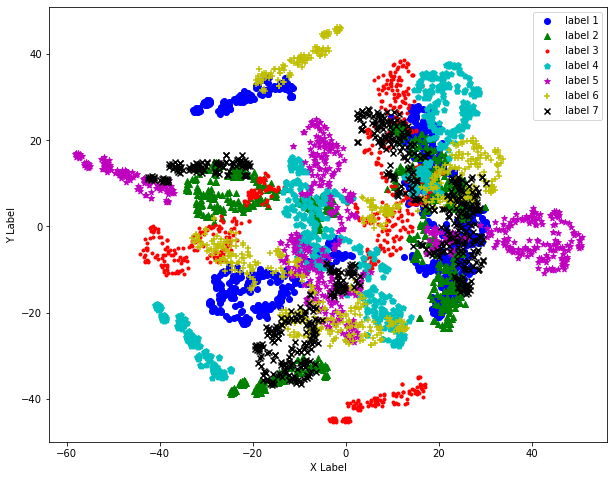

In [101]:
#Plot t-SNE for user1 feature data
#Read several dataset in one folder using pathlib and glob
path = 'user1/'
data_path = pathlib.Path(path)
data_files = sorted(data_path.glob('features*.csv'))

#Choose 100 points of samples
n = 100
n_components = 2
perplexity = 30
np.random.seed(100)
fea_lst = []

for i, f in enumerate(data_files):
    print(i, f.name)
    df1 = pd.read_csv(f)
    df = df1.dropna(axis='columns', how='all')
    df.fillna(method='ffill', inplace = True)
    df.fillna(method='bfill', inplace = True)
    print(df.shape)
    data = df.values
    idx = np.random.choice(data.shape[0], min(n, data.shape[0]),replace=False)
    arr = data[idx,:]
    fea_lst.append(arr)
    
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

color = ['b', 'g', 'r','c','m','y','k']
marker = ['o','^', '.','p','*','+','x']

target = range(len(fea_lst))

x=np.vstack(fea_lst)

for j in range(len(fea_lst)):
    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    trans_data = tsne.fit_transform(x)
    xs = trans_data[:,0]
    ys = trans_data[:,1]
    ax.scatter(xs, ys, c=color[j], marker=marker[j], label='label {}'.format(j+1))
    
ax.legend()
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

In [95]:
output_path = 'user1'
data_path = pathlib.Path(output_path)
files = sorted(data_path.glob('feature*.csv'))

# select 100 training samples
n = 100

# fix the random number generator
np.random.seed(100)

fea_lst = []
y_lst = []

for i, f in enumerate(files):
    print(i, f.name)
    df1 = pd.read_csv(f)
    df = df1.dropna(axis='columns', how='all')
    print("df.shape", df.shape)
    df.fillna(method='ffill', inplace = True)
    df.fillna(method='bfill', inplace = True)
    data = df.values
    idx = np.random.choice(data.shape[0], min(n, data.shape[0]),replace=False)
    arr = data[idx,:]
    fea_lst.append(arr)
    y_lst.append(np.full(arr.shape[0], i))
        
fea_name = list(df.columns)
x_data = np.vstack(fea_lst)
y_label = np.hstack(y_lst)

print(y_label)
print('x_data:',x_data.shape)
print('y_label:',y_label.shape)

clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Build a forest of trees from the training set (X, y)
clf.fit(x_data, y_label) 

# Returns the mean accuracy
print("mean accuracy:", clf.score(x_data, y_label)) 

print(clf.feature_importances_)
fea_dict= {}
for j, fea in enumerate(fea_name):
    fea_dict[fea] = clf.feature_importances_[j]
    
fea_import = [(v, k) for k, v in fea_dict.items()]
fea_import = sorted(fea_import, reverse = True)
print(fea_import)

0 features_1.csv
df.shape (1034, 48)
1 features_2.csv
df.shape (27, 48)
2 features_3.csv
df.shape (342, 48)
3 features_4.csv
df.shape (825, 48)
4 features_5.csv
df.shape (96, 48)
5 features_6.csv
df.shape (88, 48)
6 features_7.csv
df.shape (2575, 48)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

mean accuracy: 1.0
[0.04951652 0.0106866  0.0102675  0.03465756 0.04130592 0.01110516
 0.01443044 0.04379596 0.00507555 0.02294793 0.01019507 0.0156923
 0.01133804 0.02650872 0.0213428  0.01163344 0.0071435  0.00576741
 0.01031742 0.0119722  0.00517167 0.01824746 0.0130845  0.02316652
 0.03769757 0.02085364 0.01519629 0.03872607 0.03813267 0.01380549
 0.01869815 0.03687287 0.00677604 0.01995841 0.01959843 0.02428541
 0.02790559 0.01756869 0.02267341 0.02711652 0.033539   0.01984392
 0.00937489 0.02913736 0.00493662 0.02673338 0.01695216 0.0382472 ]
[(0.04951652425153214, 'mean_(0)'), (0.04379596301660842, ' rms_(0).1'), (0.04130592145442768, 'mean_(0).1'), (0.03872606892231019, ' rms_(0).6'), (0.03824719832603841, ' rms_(0).11'), (0.038132672908935426, 'mean_(0).7'), (0.03769756782270299, 'mean_(0).6'), (0.036872871022289394, ' rms_(0).7'), (0.03465755881811907, ' rms_(0)'), (0.03353900145524674, 'mean_(0).10'), (0.02913736159877471, ' rms_(0).10'), (0.02790559150025895, 'mean_(0).9'),

In [96]:
for i in range(2,9):
    output_path = 'user{}'.format(i)
    data_path = pathlib.Path(output_path)
    files = sorted(data_path.glob('feature*.csv'))
    print('predict:', output_path)

    # fix the random number generator
    np.random.seed(100)

    fea_lst = []
    y_lst = []

    for i, f in enumerate(files):
        df1 = pd.read_csv(f)
        df=df1.dropna(axis='columns', how='all')
        df.fillna(method='ffill', inplace = True)
        df.fillna(method='bfill', inplace = True)
        data = df.values
        fea_lst.append(data)
        y_lst.append(np.full(data.shape[0], i))
        
    fea_name = list(df.columns)
    x_data = np.vstack(fea_lst)
    y_label = np.hstack(y_lst)
    
    #the mean accuracy
    print("mean accuracy:", clf.score(x_data, y_label))

predict: user2


/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

mean accuracy: 0.2675656493967353
predict: user3
mean accuracy: 0.02264030612244898
predict: user4


/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

mean accuracy: 0.27088337336535895
predict: user5


/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

mean accuracy: 0.5210837237726624
predict: user6
mean accuracy: 0.21923522595596756
predict: user7


/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

mean accuracy: 0.20767539476314212
predict: user8
mean accuracy: 0.15830572645527685


/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/Users/anggaraputrapratama/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#